In [144]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
%matplotlib inline


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    #features = cv2.resize(img, size).ravel() 
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
    # Return the feature vector
    #return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

(720, 1280, 3) uint8
(64, 64, 3) float32
[ 0.61176473  0.65882355  0.63921571]
1
0.0


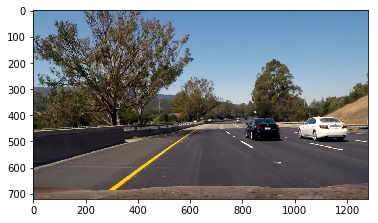

In [146]:
img = mpimg.imread('test_images/test6.jpg')
img2 = mpimg.imread('vehicles/GTI_Far/image0000.png')
print (img.shape, img.dtype)
print (img2.shape, img2.dtype)
print (img2[0][0])
#img2 *= 255
#img2.astype(np.uint8)
#plt.imshow(img2)

img3 = cv2.cvtColor(img2, cv2.COLOR_RGB2YUV)
imgs = []
imgs.append('vehicles/GTI_Far/image0000.png')
features = extract_features(imgs, cspace='YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
print (len(features))

# Create an array stack of feature vectors
X = np.array(features).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

print (np.amin(X))
plt.imshow(img/255)

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


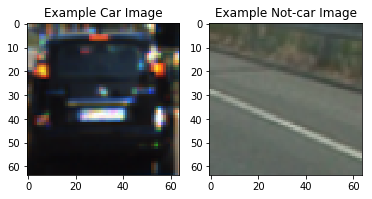

In [147]:
images1 = glob.glob('./vehicles/GTI_Far/*.png')
images2 = glob.glob('./vehicles/GTI_Left/*.png')
images3 = glob.glob('./vehicles/GTI_MiddleClose/*.png')
images4 = glob.glob('./vehicles/GTI_Right/*.png')
images5 = glob.glob('./vehicles/KITTI_extracted/*.png')

cars = images1 + images2 + images3 + images4 + images5

images6 = glob.glob('./non-vehicles/Extras/*.png')
images7 = glob.glob('./non-vehicles/GTI/*.png')

notcars = images6 + images7

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

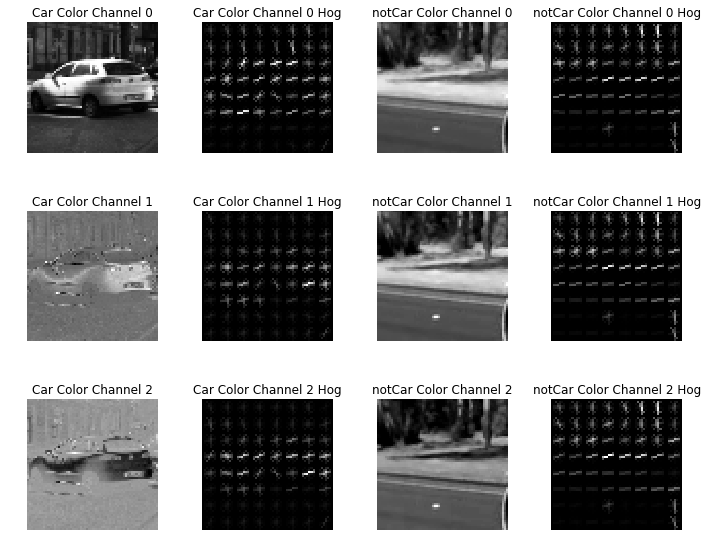

In [290]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

car_image = car_image.astype(np.float32)/255
car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)

car_hog_0 = car_image[:, :, 0]
car_hog_1 = car_image[:, :, 1]
car_hog_2 = car_image[:, :, 2]

car_features0, car_hog_img0 = get_hog_features(car_hog_0, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
_, car_hog_img1 = get_hog_features(car_hog_1, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
_, car_hog_img2 = get_hog_features(car_hog_2, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)

notcar_hog_0 = notcar_image[:, :, 0]
notcar_hog_1 = notcar_image[:, :, 1]
notcar_hog_2 = notcar_image[:, :, 2]

_, notcar_hog_img0 = get_hog_features(notcar_hog_0, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
_, notcar_hog_img1 = get_hog_features(notcar_hog_1, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
_, notcar_hog_img2 = get_hog_features(notcar_hog_2, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)


fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes[0, 0].imshow(car_image[:, :, 0], cmap='gray'); axes[0, 0].set_title("Car Color Channel 0")
axes[0, 1].imshow(car_hog_img0, cmap='gray'); axes[0, 1].set_title("Car Color Channel 0 Hog")
axes[1, 0].imshow(car_image[:, :, 1], cmap='gray'); axes[1, 0].set_title("Car Color Channel 1")
axes[1, 1].imshow(car_hog_img1, cmap='gray'); axes[1, 1].set_title("Car Color Channel 1 Hog")
axes[2, 0].imshow(car_image[:, :, 2], cmap='gray'); axes[2, 0].set_title("Car Color Channel 2")
axes[2, 1].imshow(car_hog_img2, cmap='gray'); axes[2, 1].set_title("Car Color Channel 2 Hog")

axes[0, 2].imshow(notcar_image[:, :, 0], cmap='gray'); axes[0, 2].set_title("notCar Color Channel 0")
axes[0, 3].imshow(notcar_hog_img0, cmap='gray'); axes[0, 3].set_title("notCar Color Channel 0 Hog")
axes[1, 2].imshow(notcar_image[:, :, 1], cmap='gray'); axes[1, 2].set_title("notCar Color Channel 1")
axes[1, 3].imshow(notcar_hog_img1, cmap='gray'); axes[1, 3].set_title("notCar Color Channel 1 Hog")
axes[2, 2].imshow(notcar_image[:, :, 2], cmap='gray'); axes[2, 2].set_title("notCar Color Channel 2")
axes[2, 3].imshow(notcar_hog_img2, cmap='gray'); axes[2, 3].set_title("notCar Color Channel 2 Hog")
[ax.axis("off") for axe in axes for ax in axe]
fig.tight_layout()
plt.show()

In [179]:
# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = (32, 32)
histbin = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

car_features = extract_features(cars, cspace=colorspace, spatial_size=spatial,
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=spatial,
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, y_train = shuffle(scaled_X, y)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial, 'and', histbin,'histogram bins')
print('Using hog feature:', orient, pix_per_cell, cell_per_block, hog_channel)
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 18
print('My SVC predicts:  ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

dist_pickle = {}
dist_pickle["svc"] = svc 
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial
dist_pickle["hist_bins"] = histbin
pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ) )

Using spatial binning of: (32, 32) and 32 histogram bins
Using hog feature: 9 8 2 ALL
Feature vector length: 8460
28.51 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:   [ 0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  0.  0.  0.]
For these 18 labels:  [ 0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  0.  0.  0.]
0.01286 Seconds to predict 18 labels with SVC


In [297]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #print ("pixel： ", ctrans_tosearch[0][0], ctrans_tosearch.dtype)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                                  
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #print (test_features.shape)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, box_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

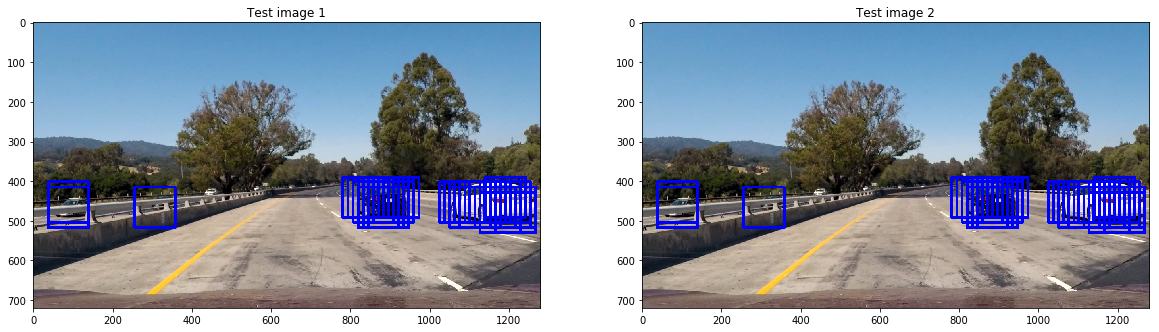

In [318]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

ystart = 390
ystop = 656
scale = 1.6

img1 = mpimg.imread('test_images/test1.jpg')

img2 = mpimg.imread('test_images/test6.jpg')


out_img1, bbox_list = find_cars(img1, ystart, ystop, scale, svc, X_scaler, 
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

out_img2, bbox_list = find_cars(img1, ystart, ystop, scale, svc, X_scaler, 
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
f,(ax1,ax2) = plt.subplots(1,2,figsize =(20,10))
ax1.imshow(out_img1)
ax2.imshow(out_img2)
ax1.set_title('Test image 1')
ax2.set_title('Test image 2')

plt.show()

In [ ]:
#Generate consecutive frames
cap = cv2.VideoCapture("project_video.mp4")
for i in range(6):
    cap.set(1, 1000+i)
    _, frame = cap.read()
    cv2.imwrite("examples/frame"+str(i)+".jpg", frame)

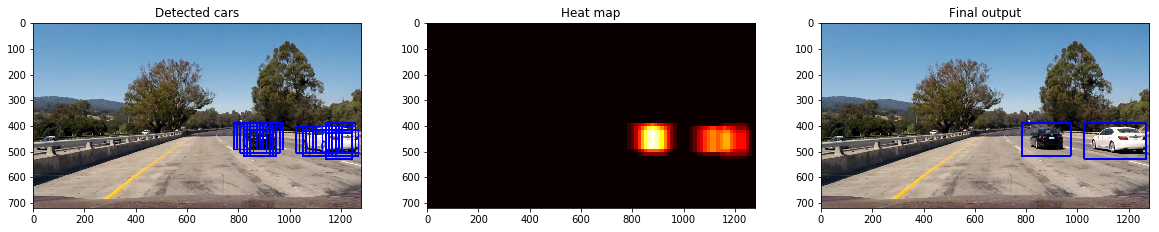

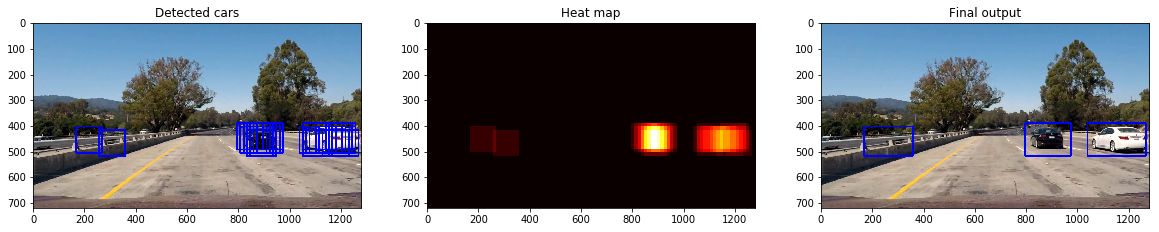

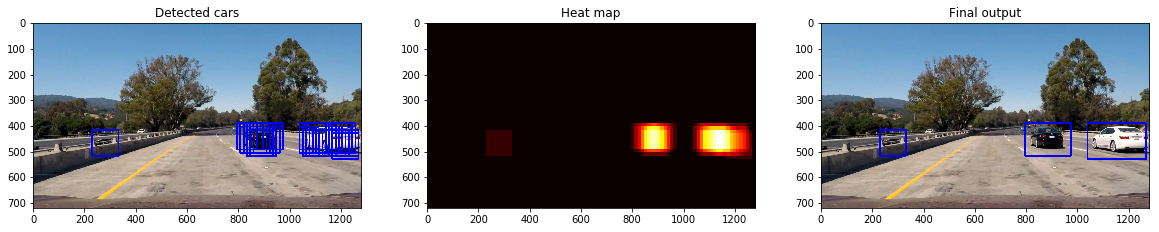

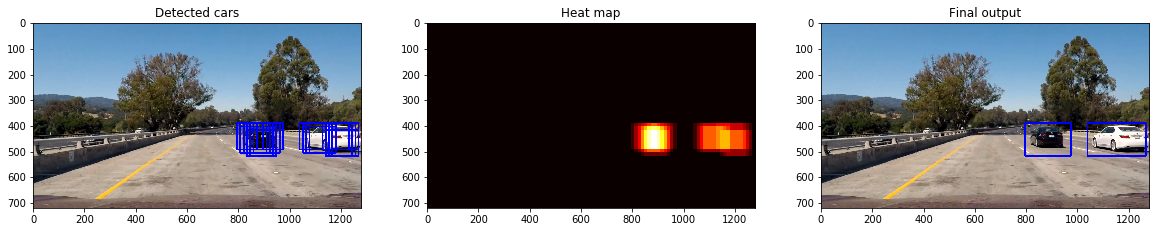

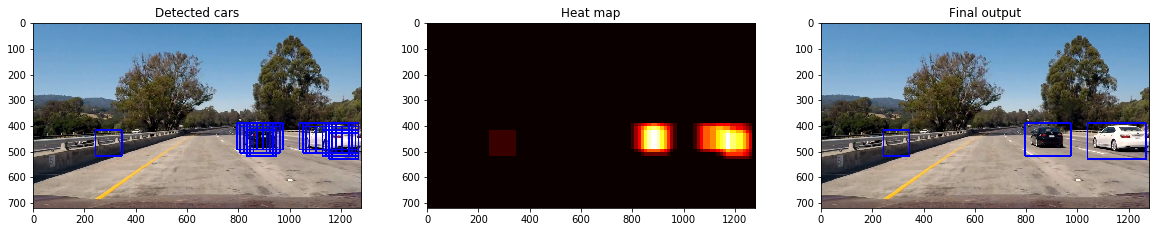

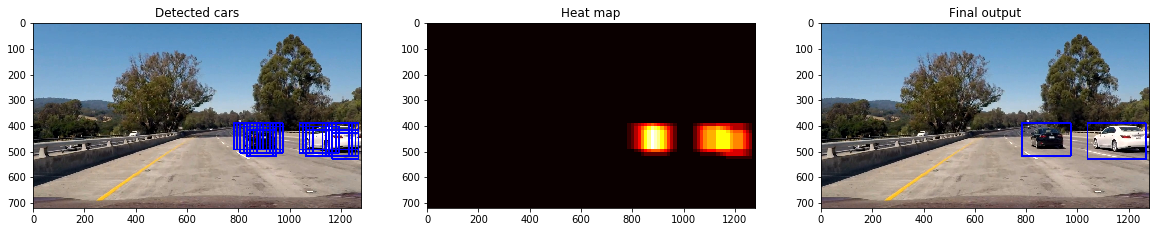

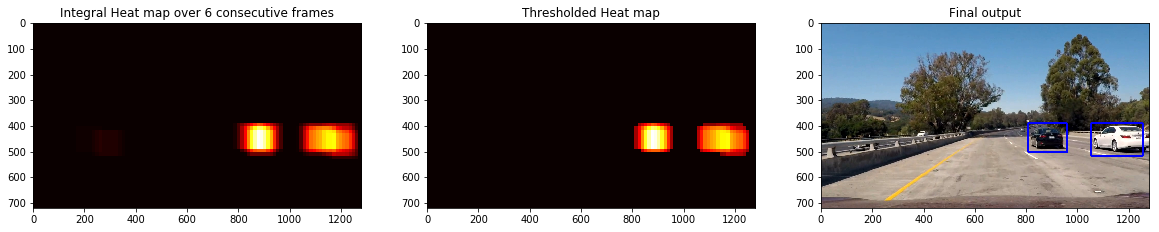

In [314]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

ystart = 390
ystop = 656
scale = 1.6
imgs = []
all_bbox_list = []
out_imgs = []

cumulative_heat = np.zeros((6,720,1280))

for i in range(6):
    img = mpimg.imread('examples/frame'+str(i)+'.jpg')
    imgs.append(img)

    out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    out_imgs.append(out_img)
    all_bbox_list.append(bbox_list)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
    cumulative_heat[i] = heat

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize =(20,10))
    ax1.imshow(out_img)
    ax2.imshow(heatmap,cmap = 'hot')
    ax3.imshow(draw_img)
    ax1.set_title('Detected cars')
    ax2.set_title('Heat map')
    ax3.set_title('Final output')

heat = np.sum(cumulative_heat, axis=0)

heatmap = np.clip(heat, 0, 255)

heat = apply_threshold(heat,15)

# Visualize the heatmap when displaying    
thresholded_heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(thresholded_heatmap)
draw_img = draw_labeled_bboxes(np.copy(imgs[5]), labels)

f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize =(20,10))
ax1.imshow(heatmap, cmap = 'hot')
ax2.imshow(thresholded_heatmap, cmap = 'hot')
ax3.imshow(draw_img)
ax1.set_title('Integral Heat map over 6 consecutive frames')
ax2.set_title('Thresholded Heat map')
ax3.set_title('Final output')

plt.show()


In [315]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

heat = np.zeros_like(image[:,:,0]).astype(np.float)

n_frames = 0
buffer_size = 6
cumulative_heat = np.zeros((buffer_size,720,1280))

def process_image(image):
    
    global n_frames, heat, cumulative_heat
    
    out_img, bbox_list = find_cars(image, ystart, ystop, scale, svc, 
                                   X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    frame_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    frame_heat = add_heat(frame_heat, bbox_list)
    cumulative_heat[n_frames] = frame_heat
    
    heat = np.sum(cumulative_heat, axis=0)
    
    n_frames = (n_frames + 1) % buffer_size    
        
    heat = apply_threshold(heat,15)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [317]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

output_file = 'output.mp4'
#clip1 = VideoFileClip("test_video.mp4")
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [16:09<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 15min 37s, sys: 26.5 s, total: 16min 4s
Wall time: 16min 10s
